In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows',  99)

from tqdm import tqdm

# Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
print(len(train_df.columns))
for col in train_df.columns:
    print(col, train_df[col].unique())

12
User_ID [1000001 1000002 1000003 ... 1004113 1005391 1001529]
Product_ID ['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']
Gender ['F' 'M']
Age ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category ['A' 'C' 'B']
Stay_In_Current_City_Years ['2' '4+' '3' '1' '0']
Marital_Status [0 1]
Product_Category_1 [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Product_Category_2 [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3 [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]
Purchase [ 8370 15200  1422 ...   135   123   613]


In [18]:
num_of_training_samples = len(train_df)
df_combined = train_df.append(test_df, sort = False)

In [6]:
#Categorical Encoding
df_combined['Product_Category_2'] = df_combined['Product_Category_2'].fillna(value = df_combined['Product_Category_2'].value_counts().index[0])
df_combined['Product_Category_3'] = df_combined['Product_Category_3'].fillna(value = df_combined['Product_Category_3'].value_counts().index[0])
df_combined_filled_na = df_combined.copy()
# df_combined = pd.get_dummies(df_combined, drop_first = True, columns = ['City_Category', 'Age', 'Gender','Occupation',
#                                                               'Stay_In_Current_City_Years', 'Marital_Status',
#                                                               'Product_Category_1','Product_Category_2',
#                                                                'Product_Category_3'])

In [10]:
df_combined_filled_na = df_combined_filled_na.reset_index(drop = True)
df_combined_filled_na.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,16.0,8370.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,16.0,1422.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,16.0,1057.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,16.0,7969.0


In [8]:
# feature representing the count of each user
def getCountVar(count_df, var_name, col_name):
    compute_df = count_df.copy()
    count_series = count_df.groupby([var_name]).count()['Occupation']
#     print(count_series)
    for i,row in tqdm(count_series.iteritems()):
        compute_df.loc[compute_df[compute_df[var_name] == i].index, col_name] = row
#         print(compute_df.loc[compute_df[compute_df[var_name] == i].index, col_name])
    return compute_df

In [ ]:
df_combined_filled_na[df_combined_filled_na['User_ID'] == 1000001].index

In [11]:
df_combined_filled_na.index.duplicated()

array([False, False, False, ..., False, False, False])

In [14]:
df_combined_filled_na = getCountVar(df_combined_filled_na, 'User_ID', 'User_ID_count')
df_combined_filled_na = getCountVar(df_combined_filled_na, 'Product_ID','Product_ID_count' )

5891it [01:08, 85.45it/s]
3677it [03:21, 18.29it/s]


In [15]:
df_combined_filled_na.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_count,Product_ID_count
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,16.0,8370.0,47.0,344.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,47.0,845.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,16.0,1422.0,47.0,150.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,16.0,1057.0,47.0,496.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,16.0,7969.0,107.0,283.0


In [16]:
df_combined_filled_na.to_csv('modified_combined.csv')

In [ ]:
df_combined_filled_na[df_combined_filled_na['User_ID'] == 1000001 ]

In [ ]:
df_combined_filled_na.groupby(['User_ID']).count()['Occupation']

In [30]:
y_train = df_combined_filled_na.head(num_of_training_samples)['Purchase']
df_combined_filled_na.drop(['User_ID', 'Product_ID','Purchase' ], inplace=True, axis = 1)

In [31]:
for col in df_combined_filled_na.columns:
    if(df_combined_filled_na[col].dtype == np.float64):
        df_combined_filled_na[col] = df_combined_filled_na[col].astype(np.int64)
        print(col)
df_combined_filled_na.dtypes

Product_Category_2
Product_Category_3
User_ID_count
Product_ID_count


Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years     int64
Marital_Status                 int64
Product_Category_1             int64
Product_Category_2             int64
Product_Category_3             int64
User_ID_count                  int64
Product_ID_count               int64
dtype: object

In [54]:
X_train = df_combined_filled_na.head(num_of_training_samples)
X_train_cat, X_valid_cat,y_train_cat , y_valid_cat = train_test_split(X_train,
                                                                   y_train, test_size=0.10, random_state=23)

In [29]:
cbr = CatBoostRegressor(l2_leaf_reg=5,
                        learning_rate = 0.15,
                        eval_metric = 'RMSE',
                        iterations = 500,
                        loss_function = 'RMSE',
                        depth=15,
                        cat_features = list(range(0,9)))

In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) #2567 for 149 (wo) 2566.1102712 (199)

In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) #2548 350

In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) #2547 650 #shrinked one 403

In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) #depth 16 interrupted

In [33]:
y_valid_cat.shape

(55007,)

In [ ]:
#Full train set
X_train = df_combined_filled_na.head(num_of_training_samples)
y_train = train_df['Purchase']
cbr.fit(X_train, y_train, plot=True) 

In [45]:
X_test = df_combined_filled_na.tail(len(df_combined) - num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr.predict(X_test)

test_df_operate.to_csv('submission_cbr_460.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
cbr.shrink(460)

In [47]:
df_combined_filled_na.dtypes


Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                 int64
Product_Category_1             int64
Product_Category_2             int64
Product_Category_3             int64
User_ID_count                  int64
Product_ID_count               int64
dtype: object

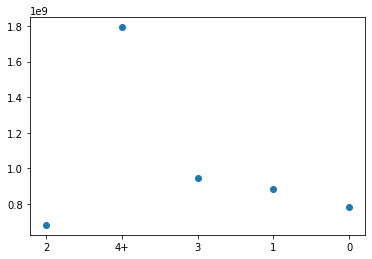

In [56]:
import matplotlib.pyplot as plt
plt.scatter(train_df['Stay_In_Current_City_Years'].unique(), train_df.groupby(['Stay_In_Current_City_Years']).sum()['Purchase'])

In [58]:
train_df['Stay_In_Current_City_Years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [10]:
#Directly from processed file
df_combined_filled_na = pd.read_csv('modified_combined.csv', index_col = 0)
df_combined_filled_na.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_count,Product_ID_count
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,16.0,8370.0,47.0,344.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,47.0,845.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,16.0,1422.0,47.0,150.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,16.0,1057.0,47.0,496.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,16.0,7969.0,107.0,283.0


In [27]:
df_combined_filled_na['Stay_In_Current_City_Years'].value_counts()

1    276425
2    145427
3    135428
4    120671
0    105716
Name: Stay_In_Current_City_Years, dtype: int64

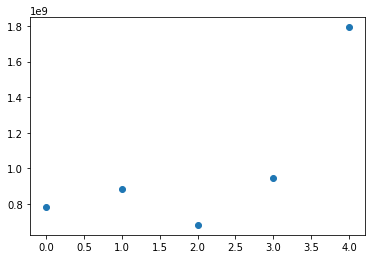

In [28]:
import matplotlib.pyplot as plt
plt.scatter(df_combined_filled_na['Stay_In_Current_City_Years'].unique(), df_combined_filled_na.groupby(['Stay_In_Current_City_Years']).sum()['Purchase'])

In [33]:
df_combined_filled_na.columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'User_ID_count',
       'Product_ID_count'],
      dtype='object')

In [34]:
cbr = CatBoostRegressor(l2_leaf_reg=5,
                        learning_rate = 0.125,
                        eval_metric = 'RMSE',
                        iterations = 650,
                        loss_function = 'RMSE',
                        depth=16,
                        cat_features = [0,1,2,3,5,6,7,8])


In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) #2557.8160811 (397) not good

In [ ]:
X_test = df_combined_filled_na.tail(len(df_combined) - num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr.predict(X_test)

test_df_operate.to_csv('submission_cbr_460.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

### GRID Search for reg, depth, learning rate

In [62]:
cbr_1 = CatBoostRegressor(eval_metric = 'RMSE',
                        iterations = 150,
                        loss_function = 'RMSE',
                        cat_features = [0,1,2,3,5,6,7,8])


In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {'l2_leaf_reg': list(np.arange(4,7)),
            'learning_rate': [0.15,0.2],
            'depth':[15,16]}

grid = GridSearchCV(estimator = cbr_1, param_grid=param_grid,cv=3,scoring='neg_mean_squared_error')


1. 2382   4 0.15 15
2. 2387   
3. 2419   
4. 2301   4 0.2 16 4 0.15 16
5. 2322   5 0.15 15
6. 2310   5 0.15 16
7. 2400   5 0.2 15 4 0.2 15
8. 2413   5 0.2 16
9. 

In [ ]:
grid.fit(X_train, y_train)

In [69]:
grid.best_score_

-7452759.826358338

In [71]:
grid.best_params_

{'depth': 16, 'l2_leaf_reg': 4, 'learning_rate': 0.2}

In [ ]:
grid.cv_results_

In [73]:
import joblib
joblib.dump(grid, 'grid.pkl')

['grid.pkl']

In [79]:
cbr_1 = CatBoostRegressor(depth= 16, l2_leaf_reg= 5, learning_rate= 0.2,
                        eval_metric = 'RMSE',
                        iterations = 400,
                        loss_function = 'RMSE',
                        cat_features = [0,1,2,3,5,6,7,8])

In [ ]:
cbr_1.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) 

In [11]:
cbr_1.shrink(221)
X_test = df_combined_filled_na.tail(len(df_combined) - num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr_1.predict(X_test)

test_df_operate.to_csv('submission_cbr_5.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

NameError: name 'cbr_1' is not defined

### Filling na with zero and trying again
##### This worked better than filling with frequency

In [12]:
df_filled_na_0 = train_df.append(test_df, sort = False)
df_filled_na_0.reset_index(drop=True, inplace = True)
df_filled_na_0['User_ID_count'] = df_combined_filled_na['User_ID_count']
df_filled_na_0['Product_ID_count'] = df_combined_filled_na['Product_ID_count']
df_filled_na_0.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_count,Product_ID_count
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,47.0,344.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,47.0,845.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422.0,47.0,150.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057.0,47.0,496.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969.0,107.0,283.0


In [6]:
print(df_filled_na_0['Product_Category_3'].value_counts(dropna = False))

NaN     545809
16.0     46469
15.0     39968
14.0     26283
17.0     23818
5.0      23799
8.0      17861
9.0      16532
12.0     13115
13.0      7849
6.0       6888
18.0      6621
4.0       2691
11.0      2585
10.0      2501
3.0        878
Name: Product_Category_3, dtype: int64


In [92]:
print(df_filled_na_0['Product_Category_2'].value_counts(dropna = False))

NaN     245982
8.0      91317
14.0     78834
2.0      70498
16.0     61687
15.0     54114
5.0      37165
4.0      36705
6.0      23575
11.0     20230
17.0     19104
13.0     15054
9.0       8177
12.0      7801
10.0      4420
3.0       4123
18.0      4027
7.0        854
Name: Product_Category_2, dtype: int64


In [13]:
#NaN is high in both categories so fill them with 0
df_filled_na_0.fillna(0,inplace = True)
print(df_filled_na_0['Product_Category_2'].value_counts(dropna = False))

0.0     245982
8.0      91317
14.0     78834
2.0      70498
16.0     61687
15.0     54114
5.0      37165
4.0      36705
6.0      23575
11.0     20230
17.0     19104
13.0     15054
9.0       8177
12.0      7801
10.0      4420
3.0       4123
18.0      4027
7.0        854
Name: Product_Category_2, dtype: int64


In [14]:
df_filled_na_0.index.duplicated().sum()

0

In [15]:
df_filled_na_0.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
User_ID_count                 float64
Product_ID_count              float64
dtype: object

In [16]:
df_filled_na_0.Stay_In_Current_City_Years.replace('4+', 4,inplace=True)
df_filled_na_0['Stay_In_Current_City_Years'] = df_filled_na_0['Stay_In_Current_City_Years'].astype('int64')
for col in df_filled_na_0.columns:
    if(df_filled_na_0[col].dtype == np.float64):
        df_filled_na_0[col] = df_filled_na_0[col].astype(np.int64)
        print(col)
df_filled_na_0.dtypes

Product_Category_2
Product_Category_3
Purchase
User_ID_count
Product_ID_count


User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years     int64
Marital_Status                 int64
Product_Category_1             int64
Product_Category_2             int64
Product_Category_3             int64
Purchase                       int64
User_ID_count                  int64
Product_ID_count               int64
dtype: object

In [12]:
df_filled_na_0.dtypes

User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years     int64
Marital_Status                 int64
Product_Category_1             int64
Product_Category_2             int64
Product_Category_3             int64
dtype: object

### Used user_ID and product id without removing and trying again

In [19]:
y_train = df_filled_na_0.head(num_of_training_samples)['Purchase']
# df_filled_na_0.drop(['User_ID', 'Product_ID','Purchase' ], inplace=True, axis = 1)
df_filled_na_0.drop(['Purchase' ], inplace=True, axis = 1)

In [20]:
X_train = df_filled_na_0.head(num_of_training_samples)
X_train_cat, X_valid_cat,y_train_cat , y_valid_cat = train_test_split(X_train,
                                                                   y_train, test_size=0.10, random_state=23)
X_train.shape

(550068, 13)

In [21]:
cbr_2 = CatBoostRegressor(l2_leaf_reg=5,
                        learning_rate = 0.15,
                        eval_metric = 'RMSE',
                        iterations = 200,
                        loss_function = 'RMSE',
                        depth=16,
                        cat_features = [0,1,2,3,4,5,7,8,9,10])

In [ ]:
cbr_2.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) 

In [ ]:
cbr_2.get_all_params()

In [ ]:
cbr_2.fit(X_train, y_train, plot=True) 

In [29]:
cbr_2.shrink(173)
X_test = df_filled_na_0.tail(len(df_combined) - num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr_2.predict(X_test)
test_df_operate['Purchase'] = abs(test_df_operate['Purchase'])


test_df_operate.to_csv('submission_cbr_13.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
train_df['Purchase'].isnull().sum()

0

In [56]:
test_df_operate['Purchase'] = abs(test_df_operate['Purchase'])

C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
test_df_operate[test_df_operate['Purchase'] < 0].count()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [41]:
test = pd.read_csv('submission_cbr_12.csv')
test.head()

,Purchase,User_ID,Product_ID
0,16208.405865,1000004,P00128942
1,11991.789692,1000009,P00113442
2,6709.074154,1000010,P00288442
3,2617.428558,1000010,P00145342
4,2307.127199,1000011,P00053842


In [49]:
test.loc[test[test['Purchase'] < 0].index, 'Purchase'] = 0
test[test['Purchase'] < 0].count()

Purchase      0
User_ID       0
Product_ID    0
dtype: int64

In [51]:
test.to_csv('submission_cbr_12.csv',index=False)

In [112]:
df_filled_na_0.shape

(783667, 11)

In [ ]:
test_df_operate

In [141]:
joblib.dump(cbr_2,'catboost.pkl')

['catboost.pkl']

In [143]:
df_filled_na_0.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object')

In [13]:
cbr_3 = CatBoostRegressor(l2_leaf_reg=5,
                        learning_rate = 0.15,
                        eval_metric = 'RMSE',
                        iterations = 200,
                        loss_function = 'RMSE',
                        depth=16,
                        cat_features = list(range(0,len(df_filled_na_0.columns))))

In [ ]:
cbr_3.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True) 

In [ ]:
cbr_3.fit(X_train, y_train, plot=True) 

In [15]:
import joblib
joblib.dump(cbr_3,'catboost_recent.pkl')

['catboost_recent.pkl']

In [16]:
# cbr_3.shrink(170)
X_test = df_filled_na_0.tail(len(df_combined) - num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr_3.predict(X_test)

test_df_operate.to_csv('submission_cbr_11.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
